- 동결 처리에는 두 가지 모드가 존재.
  - 게으른 모드(lazy mode) 와 열성 모드(eager mode) 라고 함.
  - 특정 조건에 따라 두 모드 중 하나로 수행됨.

**Note**

- Concurrent VACUUM은 내부적으로 "lazy Vacuum"이라고도 함.
- 그러나 본 문서에서 정의한 지연 모드는 동결 처리 모드라고 정의.

- 동결 처리는 일반적으로 지연 모드에서 실행되지만 열성 모드는 특정 조건이 충족될 때 실행됨.

- 지연 모드에서 동결 처리는 대상 테이블의 해당 VM을 사용하여 데드 튜플이 포함된 페이지만 스캔.

- 대조적으로, Eager 모드는 각 페이지에 데드 튜플이 포함되어 있는지 여부에 관계없이 모든 페이지를 검색.
  - 또한 동결 처리와 관련된 시스템 카탈로그를 업데이트하고 가능하면 막힘의 불필요한 부분을 제거.

# **Lazy Mode**

- 동결 처리를 시작하면 PostgreSQL은 다음을 계산.
- FreezeLimit_txid 그리고 t_xmin이 FreezeLimit_txid보다 작은 튜플을 고정.

- FreezeLimit_txid는 다음과 같이 정의됨.

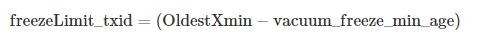

- 여기서 OldestXmin은 현재 실행 중인 트랜잭션 중 가장 오래된 txid.

- 예를 들어, VACUUM 명령이 실행될 때 세 개의 트랜잭션(txid 100, 101, 102)이 실행 중이면 OldestXmin은 100.
  - 다른 트랜잭션이 없으면 OldestXmin은 이 VACUUM 명령을 실행하는 txid.
  - 여기서, vacuum_freeze_min_age 는 구성 매개변수(기본값은 50,000,000).

- 그림은 구체적인 예를 보여줌.
  - 여기서 Table_1은 3개의 페이지로 구성되어 있으며 각 페이지에는 3개의 튜플이 있음.
  - VACUUM 명령이 실행되면 현재 txid는 50,002,500이고 다른 트랜잭션은 없음.
  - 이 경우 OldestXmin은 50,002,500.
  - 따라서 FreezeLimit_txid는 2500.
  - Freeze 처리는 다음과 같이 실행됨

**Freezing tuples in lazy mode.**

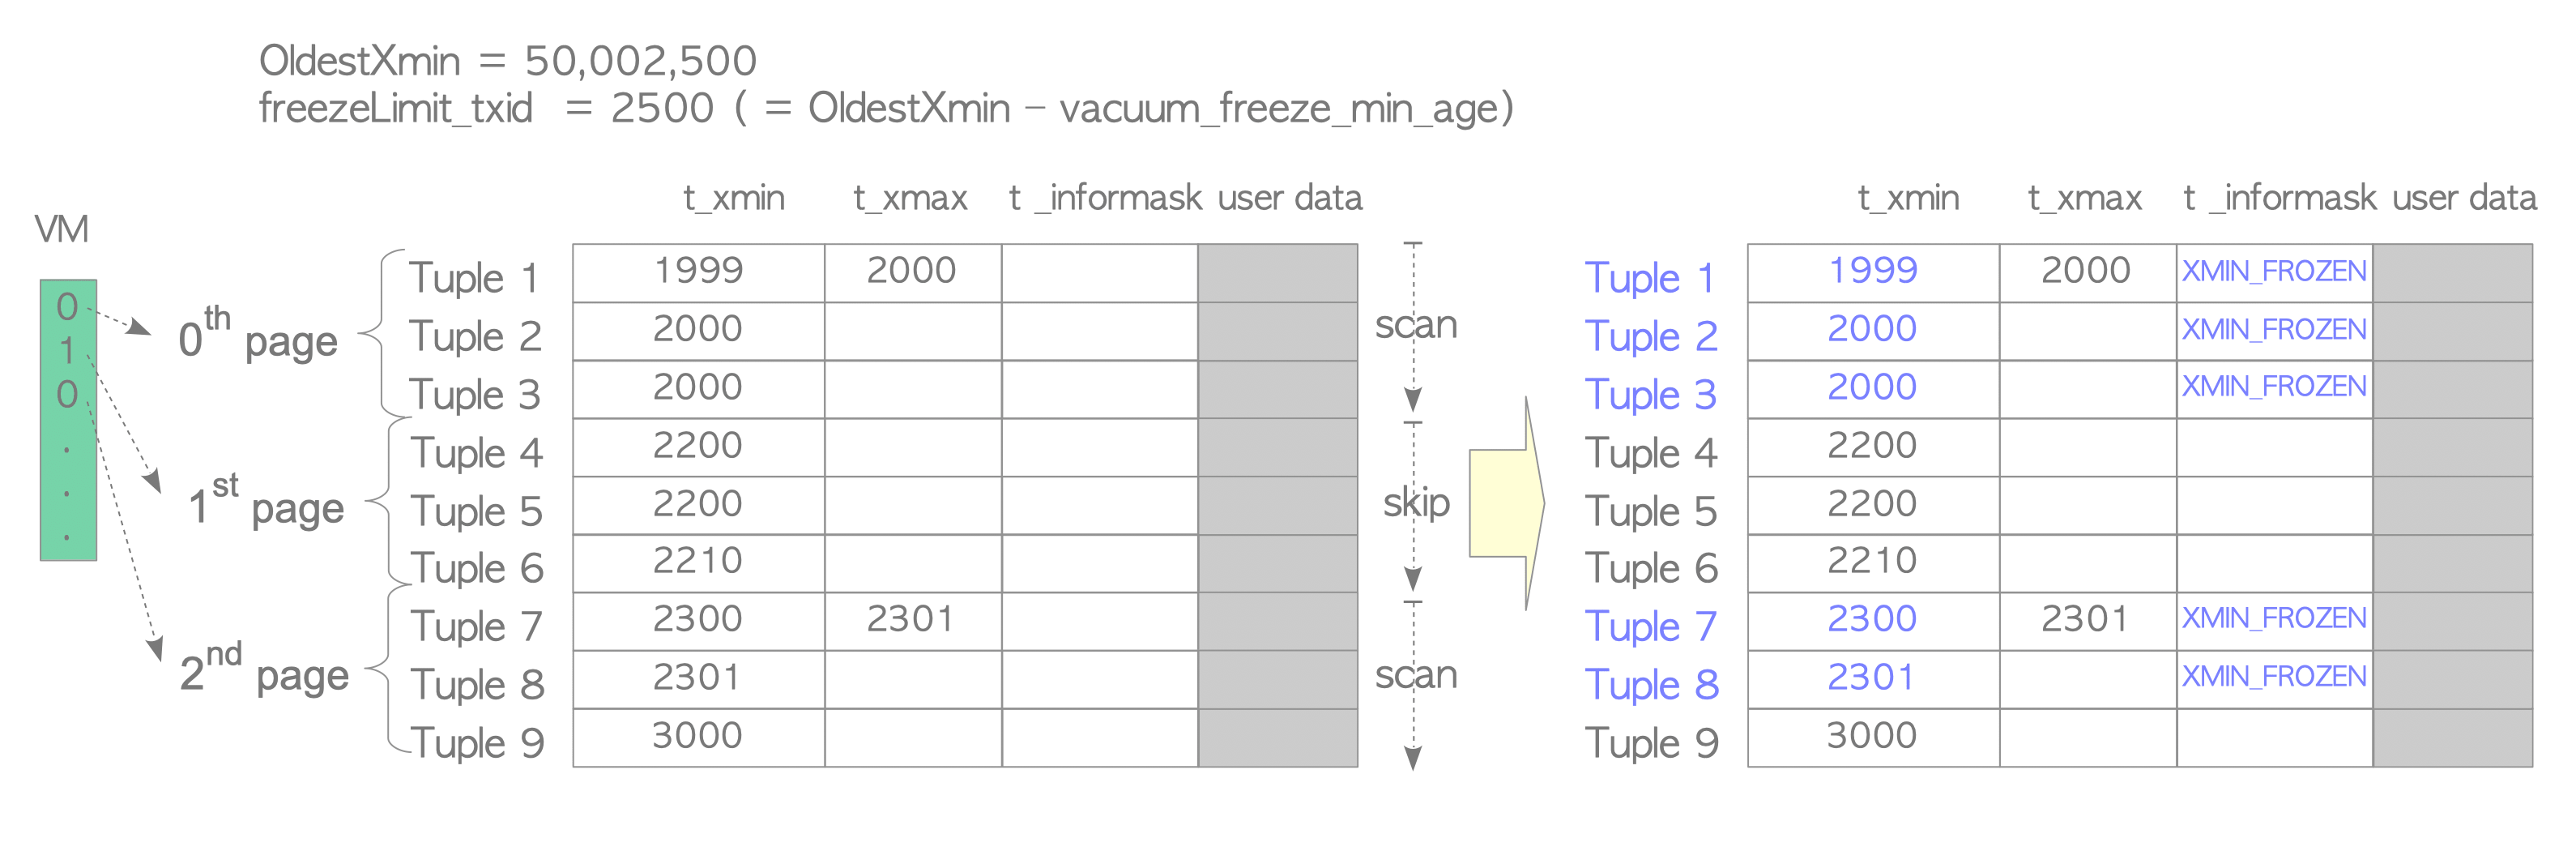

**0th page:**

- t_xmin 값이 모두 FreezeLimit_txid보다 작기 때문에 3개의 튜플이 고정됨.
- 또한 이 진공 프로세스에서는 데드 튜플로 인해 Tuple_1이 제거됨

**1st page:**

- VM을 참조하여 이 페이지를 건너뜀.

**2nd page:**

- Tuple_7 및 Tuple_8이 고정되어 있음.
- Tuple_7이 제거되었음.

- 진공 프로세스를 완료하기 전에 진공 청소와 관련된 통계가 업데이트됨(예: pg_stat_all_tables ' n_live_tup, n_dead_tup, last_vacuum, Vacuum_count 등).

- 위의 예에서 볼 수 있듯이 지연 모드는 페이지를 건너뛸 수 있기 때문에 튜플을 완전히 고정하지 못할 수도 있음.

# **Eager Mode**

- Eager 모드는 Lazy 모드의 단점을 보완한 것.
- 모든 페이지를 스캔하여 테이블의 모든 튜플을 검사하고 관련 시스템 카탈로그를 업데이트하며 가능하면 불필요한 파일과 막힌 페이지를 제거.

- Eager 모드는 다음 조건이 만족될 때 수행됨.

image.png

- 위의 조건에서, pg_database.datfrozenxid pg_database 시스템 카탈로그 의 열을 나타내며 각 데이터베이스에 대해 가장 오래된 고정 txid를 보유.
- 따라서 모든 pg_database.datfrozenxid의 값은 1821(버전 9.5에서 새 데이터베이스 클러스터 설치 직후의 초기 값)이라고 가정.
- Vacuum_freeze_table_age 는 구성 매개변수(기본값은 150,000,000).

- 그림은 구체적인 예를 보여줌.
  - Table_1에서는 Tuple_1과 Tuple_7이 모두 제거되었음.
  - 두 번째 페이지에는 Tuple_10과 Tuple_11이 삽입되었음.
  - VACUUM 명령이 실행되면 현재 txid는 150,002,000이고 다른 트랜잭션은 없음.
  - 따라서 OldestXmin은 150,002,000이고 FreezeLimit_txid는 100,002,000.
  - 이 경우 위의 조건은 만족되므로

> 1821 < (150002000-150000000)

- 따라서 Freeze 처리는 Eager 모드에서 다음과 같이 수행됨.

- (이것은 버전 9.5 이하의 동작.)

**Freezing old tuples in eager mode. (versions 9.5 or earlier)**

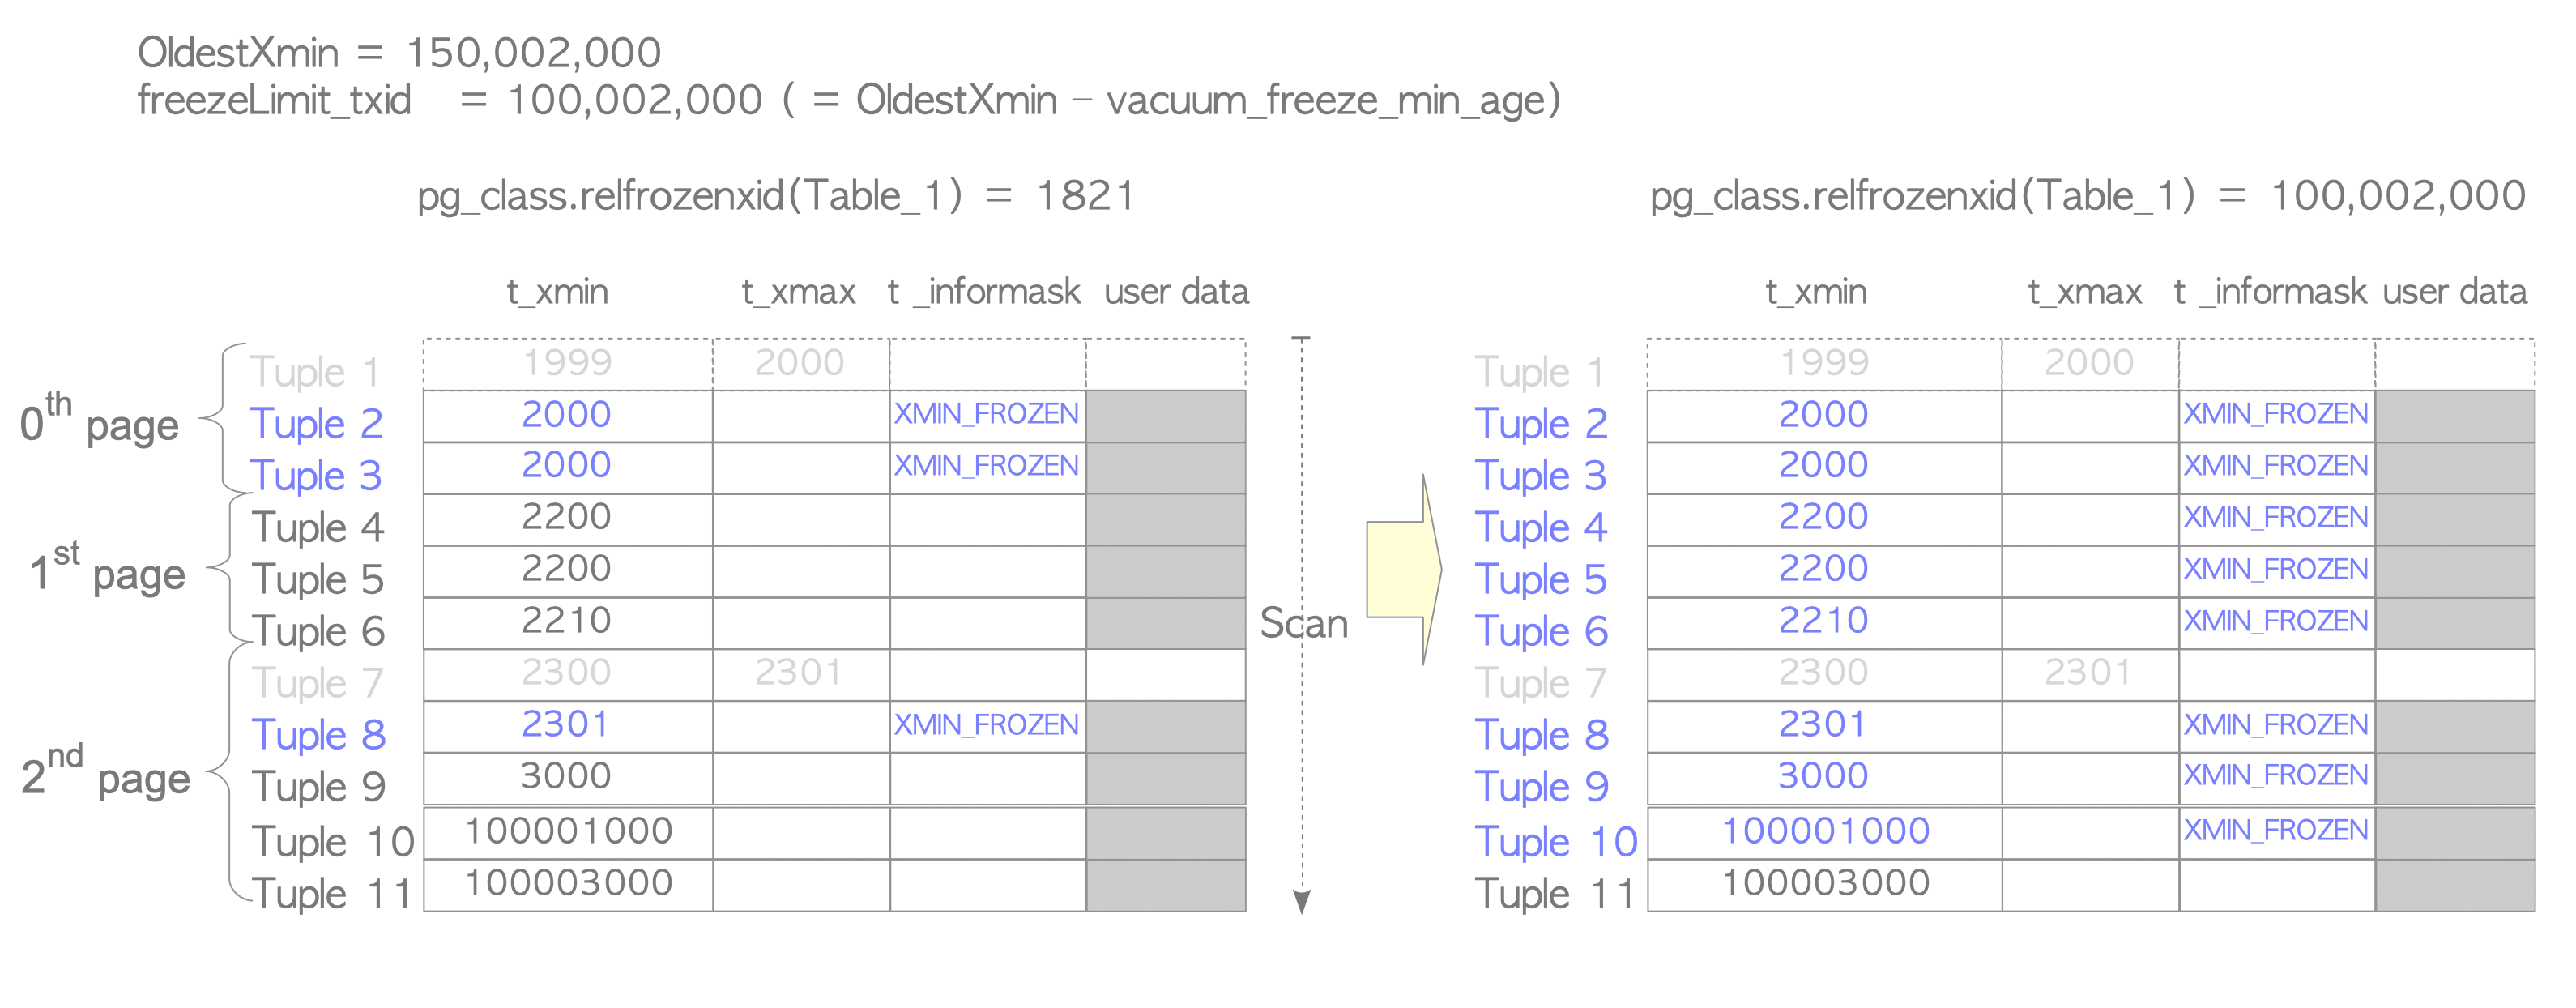

**0th page:**
- 모든 튜플이 동결되었음에도 Tuple_2 및 Tuple_3이 확인 됨.

**1st page:**
- 모든 t_xmin 값이 FreezeLimit_txid보다 작기 때문에 이 페이지의 세 튜플이 고정 됨
- 지연 모드에서는 이 페이지를 건너뜀.

**2nd page:**
- Tuple_10이 동결됨.
- Tuple_11은 그렇지 않음.

- 각 테이블을 고정한 후 대상 테이블의 pg_class.relfrozenxid가 업데이트.
- pg_class 는 시스템 카탈로그이며 각 pg_class.relfrozenxid 열은 해당 테이블의 최신 고정 xid를 보유.
- 이 예에서 Table_1의 pg_class.relfrozenxid는 현재 FreezeLimit_txid(예: 100,002,000)로 업데이트.
  - 이는 Table_1에서 t_xmin이 100,002,000 미만인 모든 튜플이 고정된다는 의미.

- 진공 프로세스를 완료하기 전에 필요한 경우 pg_database.datfrozenxid가 업데이트됨.
- 각 pg_database.datfrozenxid 열은 해당 데이터베이스의 최소 pg_class.relfrozenxid를 보유.
  - 예를 들어 Eager 모드에서 Table_1만 동결된 경우 다른 관계(현재 데이터베이스에서 볼 수 있는 다른 테이블 및 시스템 카탈로그 모두)의 pg_class.relfrozenxid가 변경되지 않았기 때문에 이 데이터베이스의 pg_database.datfrozenxid는 업데이트되지 않음.
- 현재 데이터베이스의 모든 관계가 Eager 모드에서 고정되면 이 데이터베이스에 대한 모든 관계의 pg_class.relfrozenxid가 현재 FreezeLimit_txid로 업데이트되므로 데이터베이스의 pg_database.datfrozenxid가 업데이트됨


**Relationship between pg_database.datfrozenxid and pg_class.relfrozenxid(s).**

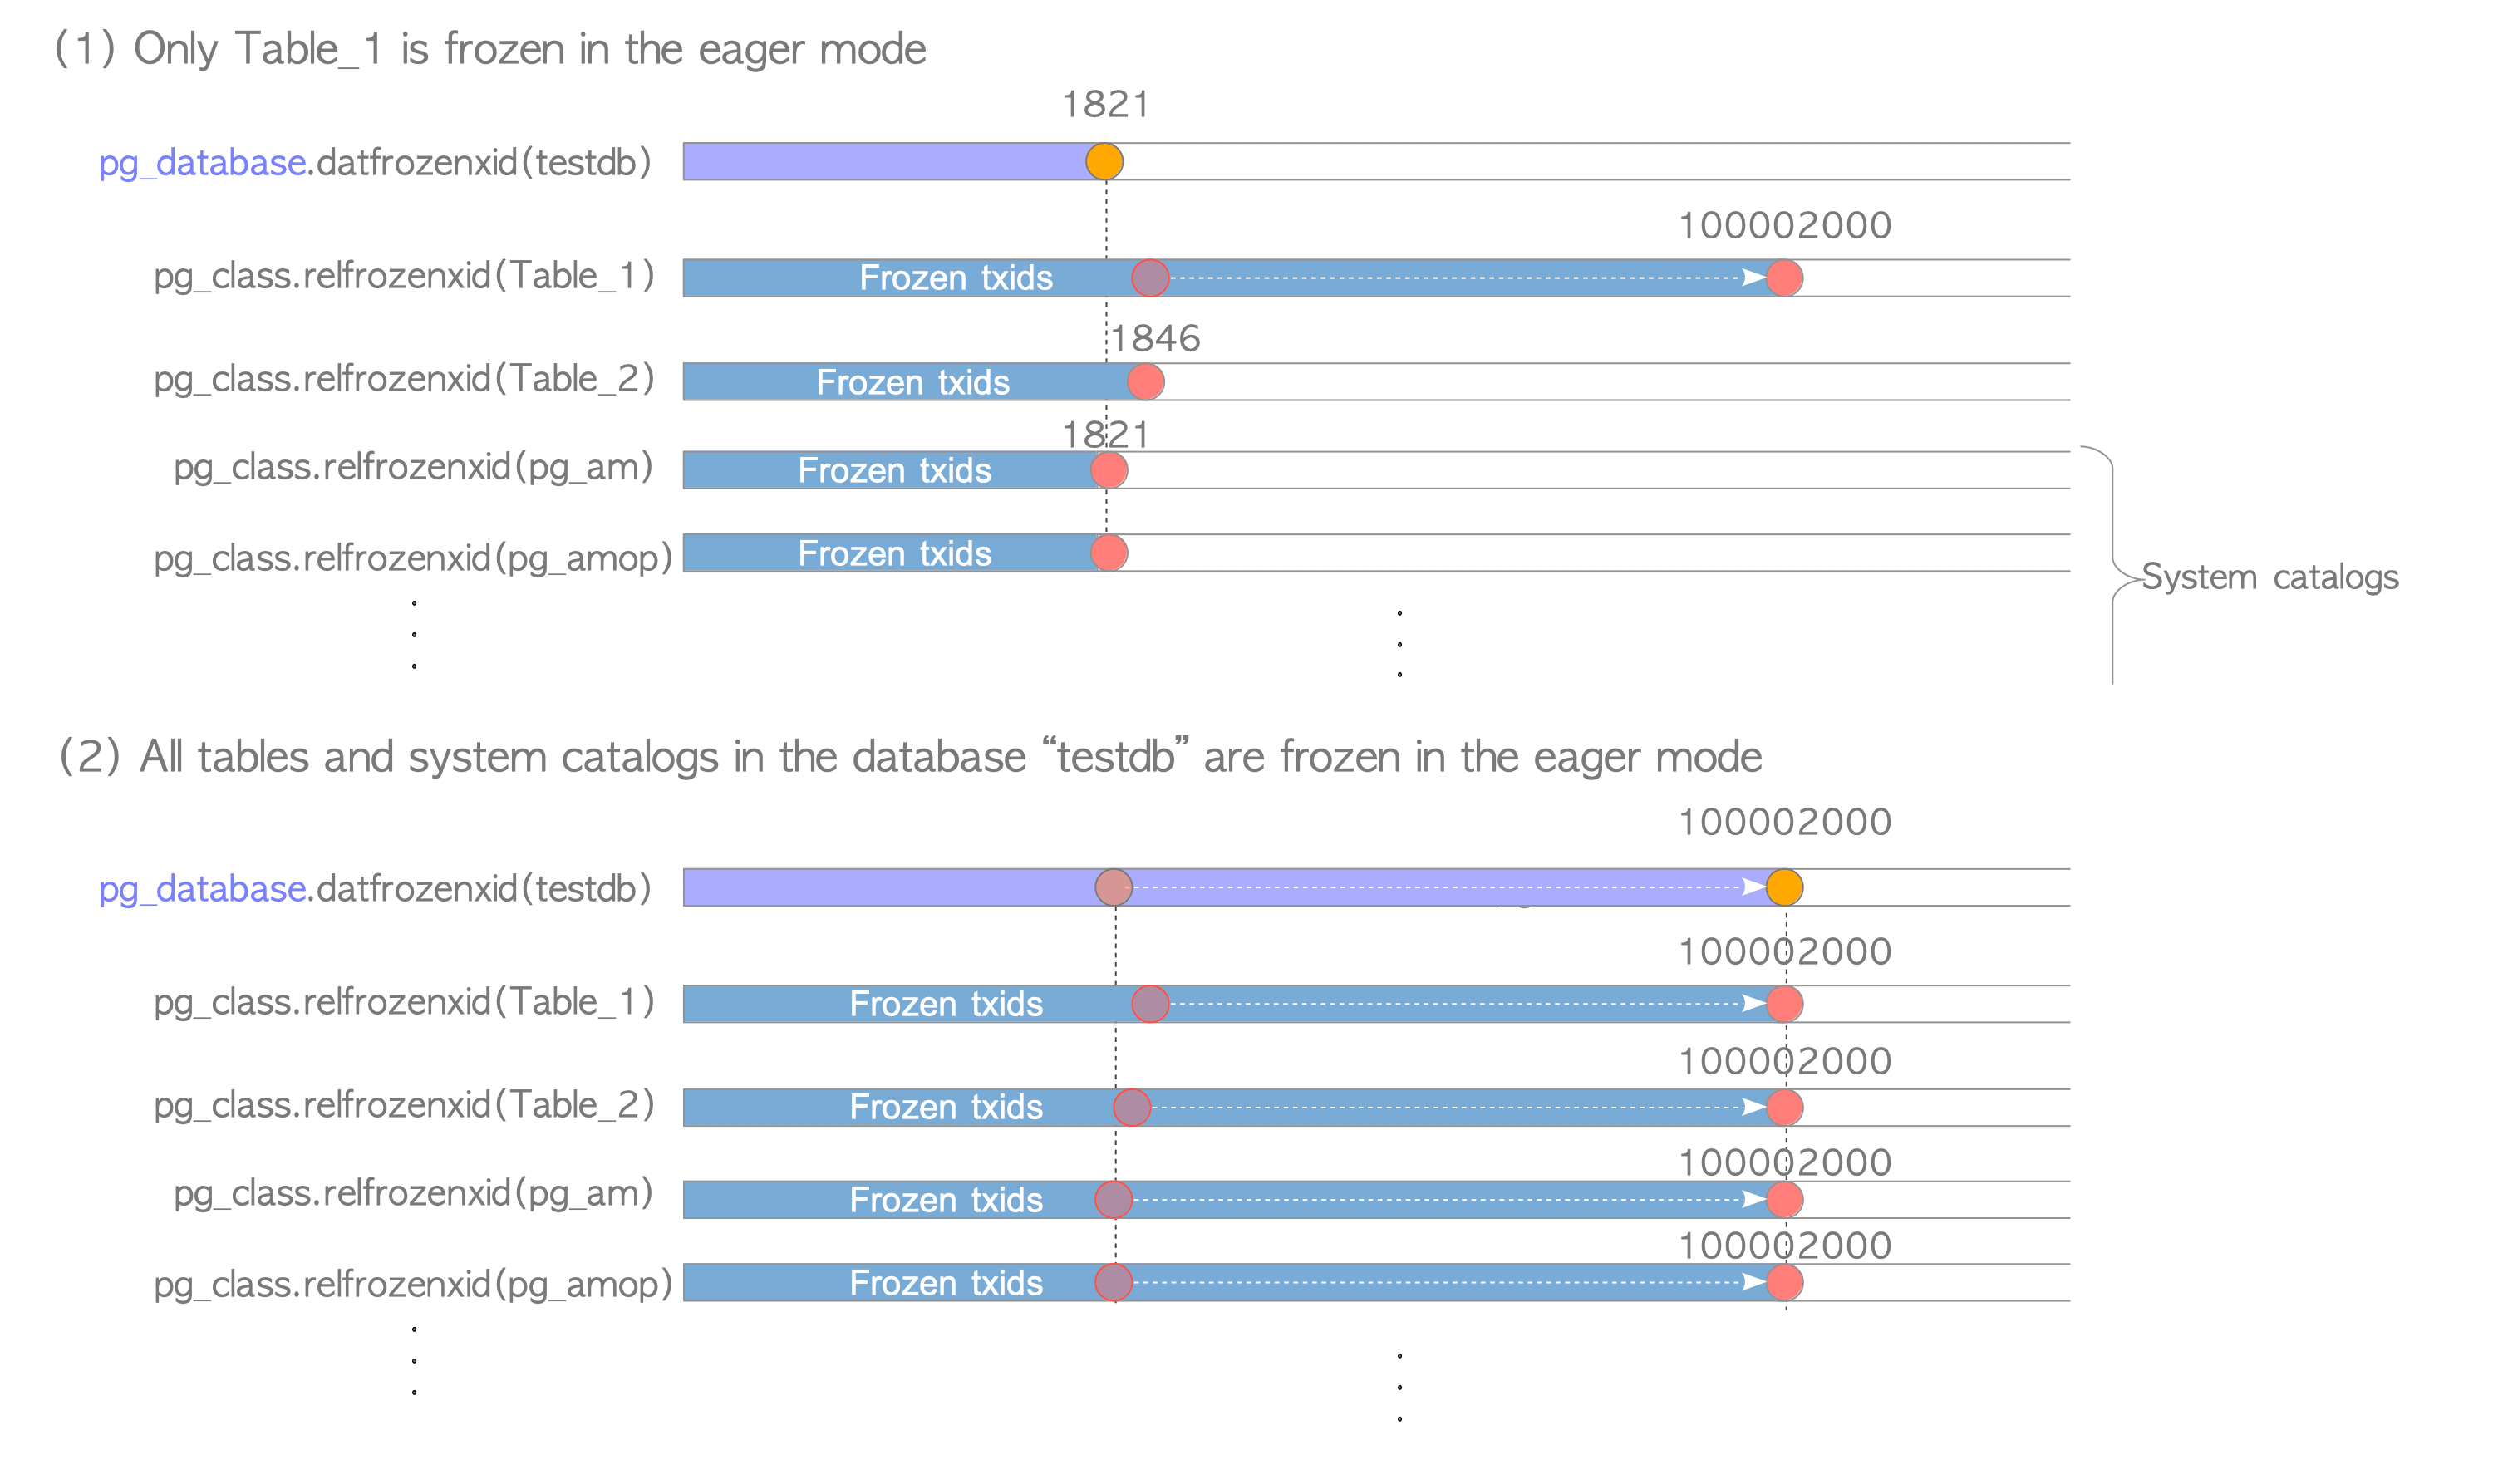

**How to show pg_class.relfrozenxid and pg_database.datfrozenxid.**

- 다음에서 첫 번째 쿼리는 'testdb' 데이터베이스에 표시되는 모든 관계의 relfrozenxids를 보여주고, 두 번째 쿼리는 'testdb' 데이터베이스의 pg_database.datfrozenxld를 보여줌.



```
testdb=# VACUUM table_1;
VACUUM
testdb=# SELECT n.nspname as "Schema", c.relname as "Name", c.relfrozenxid
             FROM pg_catalog.pg_class c
             LEFT JOIN pg_catalog.pg_namespace n ON n.oid = c.relnamespace
             WHERE c.relkind IN ('r','')
                   AND n.nspname <> 'information_schema' AND n.nspname !~ '^pg_toast'
                   AND pg_catalog.pg_table_is_visible(c.oid)
                   ORDER BY c.relfrozenxid::text::bigint DESC;
   Schema   |            Name         | relfrozenxid
------------+-------------------------+--------------
 public     | table_1                 |    100002000
 public     | table_2                 |         1846
 pg_catalog | pg_database             |         1827
 pg_catalog | pg_user_mapping         |         1821
 pg_catalog | pg_largeobject          |         1821

...

 pg_catalog | pg_transform            |         1821
(57 rows)

testdb=# SELECT datname, datfrozenxid FROM pg_database WHERE datname = 'testdb';
 datname | datfrozenxid
---------+--------------
 testdb  |         1821
(1 row)
```

**FREEZE option**

- FREEZE 옵션이 포함된 VACUUM 명령은 지정된 테이블의 모든 txid를 강제로 고정.
- 이는 Eager 모드에서 수행되지만 FreezeLimit은 OldestXmin('OldestXmin -vacuum_freeze_min_age' 아님)으로 설정됨.
  = 예를 들어 txid 5000에 의해 VACUUM FULL 명령이 실행되고 실행 중인 다른 트랜잭션이 없는 경우 OldesXmin은 5000으로 설정되고 5000 미만의 txid는 동결됨.

# **Improving Freeze Processing in Eager Mode**

- 버전 9.5 이하 버전의 Eager 모드는 항상 모든 페이지를 스캔하므로 효율적이지 않음.
  - 예를 들어, 페이지의 모든 튜플이 고정되어 있어도 0번째 페이지를 검색.

- 이 문제를 해결하기 위해 버전 9.6에서는 VM 및 고정 프로세스가 개선 됨.
  - 새 VM에는 각 페이지에서 모든 튜플이 고정되었는지 여부에 대한 정보가 있음.
  - Eager 모드에서 동결 처리가 실행되면 동결된 튜플만 포함된 페이지를 건너뛸 수 있음.

- 그림은 예를 보여줌.
  - 이 테이블을 고정할 때 VM의 정보를 참조하여 0번째 페이지를 건너뜀.
  - 첫 번째 페이지를 고정한 후 이 페이지의 모든 튜플이 고정되었으므로 관련 VM 정보가 업데이트

**Freezing old tuples in eager mode (versions 9.6 or later).**

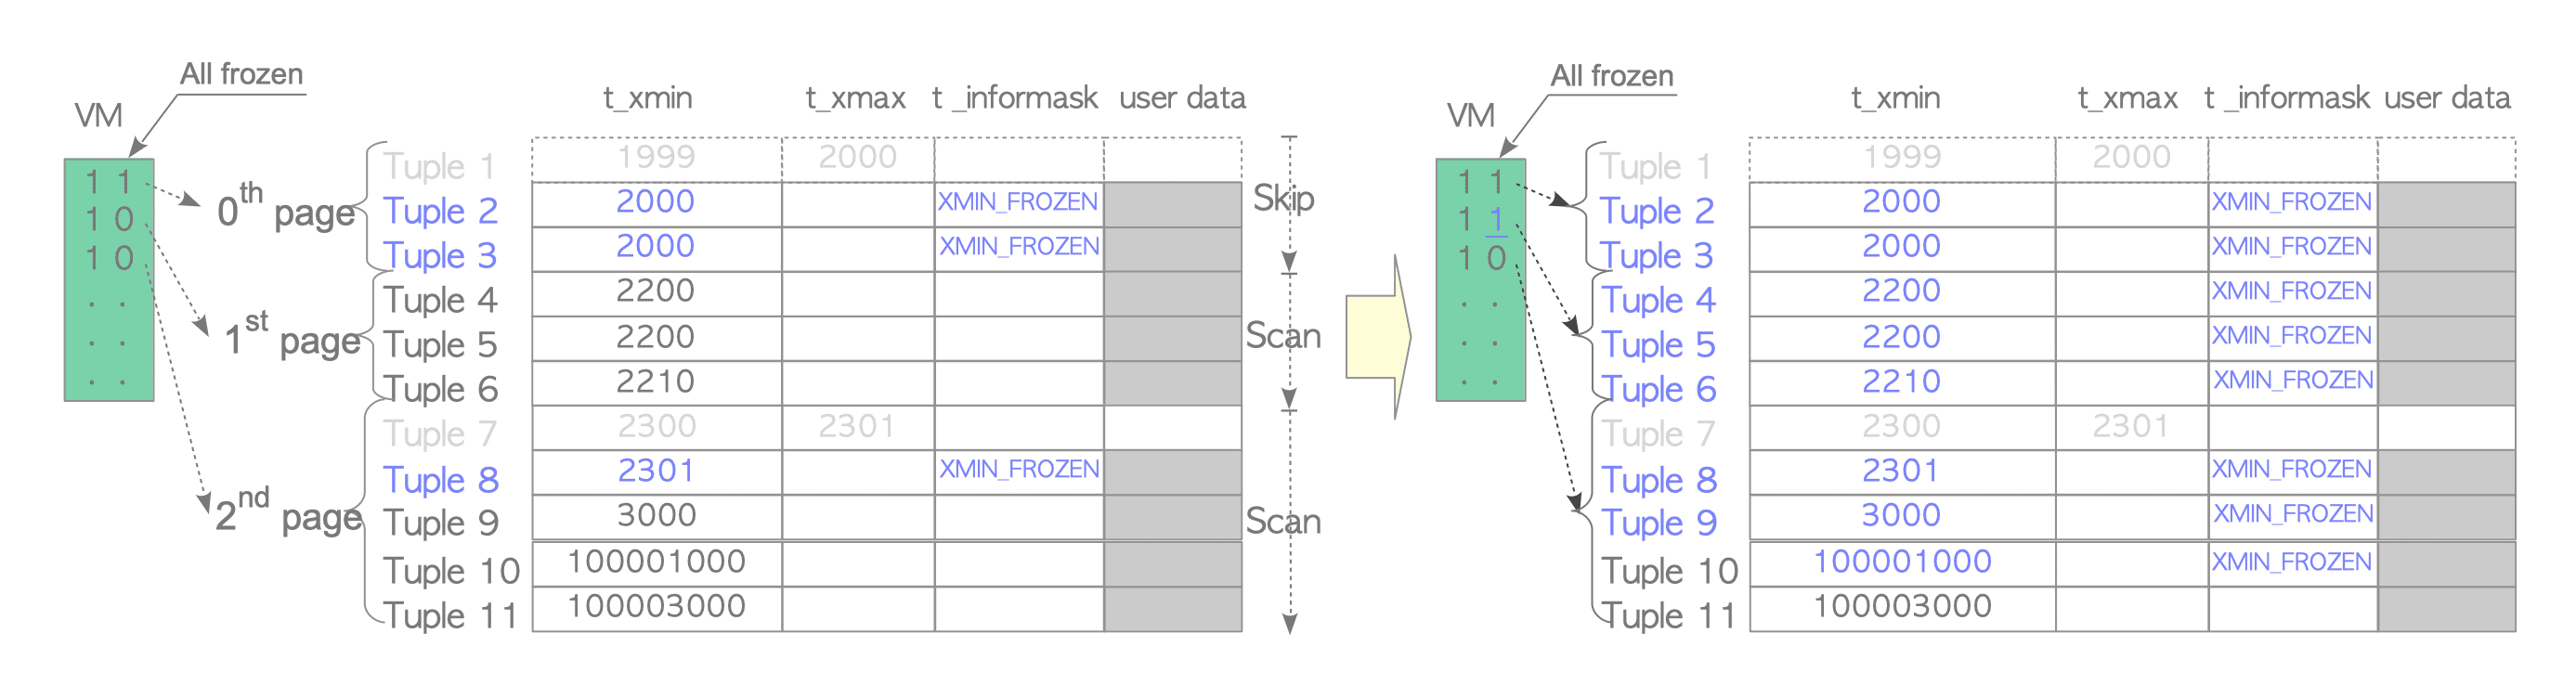